In [2]:
import os
import glob
import math
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import optimize, linalg, signal, stats

from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, RepeatedKFold, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import RFE, RFECV, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import keras
import tensorflow as tf
from keras import Model, layers, optimizers, losses, callbacks, regularizers, metrics

In [3]:
### Import Data
LN1_core = pd.read_excel(open('LN1.xlsx', 'rb'),sheet_name='core')  
LN2_core = pd.read_excel(open('LN2.xlsx', 'rb'),sheet_name='core')  
LN3_core = pd.read_excel(open('LN3.xlsx', 'rb'),sheet_name='core') 

LN1_log = pd.read_excel(open('LN1.xlsx', 'rb'),sheet_name='log')  
LN2_log = pd.read_excel(open('LN2.xlsx', 'rb'),sheet_name='log')  
LN3_log = pd.read_excel(open('LN3.xlsx', 'rb'),sheet_name='log')  

LN1_core ['WELL'] = 'LN1_core '
LN2_core ['WELL'] = 'LN2_core '
LN3_core ['WELL'] = 'LN3_core '

df_core = pd.concat([LN1_core ,LN2_core ,LN3_core])

df_core ["ln(k/phi)"] = np.log(df_core ['Kair(md)']/ df_core ['Por(%)'])
print('df_core: {}'.format(df_core.shape))
df_core.head()

df_core: (344, 23)


,Depth(m),RHOB (g/cc),DTC(rho/m),GD(g/cc),CRHOB (g/cc),GR(API),Kair(md),lnk,NPHI(v/v),PEF(b/e),...,RSHAL(ohmm),SW(v/v),SWNET(v/v),SXO(v/v),SXONET(v/v),VSHAL(v/v),WELL,Permcalc(md),PEF (b/e),ln(k/phi)
0,2993.007,2.792038,288.1894,2.649,2.212015,57.3,1950.0,7.575585,0.213187,2.675221,...,11.189480,1.000000,1.000000,1.000000,1.000000,0.951741,LN1_core,NaN,NaN,4.298440
1,2993.317,2.359790,296.7534,2.657,2.217895,82.5,947.0,6.853299,0.251199,2.522506,...,10.071730,0.581911,0.581911,0.897251,0.897251,0.352514,LN1_core,NaN,NaN,3.576154
2,2993.617,2.194946,304.3408,2.644,2.288896,93.4,977.0,6.884487,0.237218,2.513706,...,11.670710,0.335579,0.335579,0.803588,0.803588,0.146957,LN1_core,NaN,NaN,3.811793
3,2993.937,2.559232,301.3028,2.644,2.338216,77.5,149.0,5.003946,0.267802,2.574758,...,9.749550,0.948978,0.948978,0.987285,0.987285,0.697391,LN1_core,NaN,NaN,2.080785
4,2994.207,2.348028,302.3077,2.653,2.206690,91.9,2240.0,7.714231,0.251800,2.514174,...,9.494773,0.481906,0.481906,0.863907,0.863907,0.355592,LN1_core,NaN,NaN,4.418394


***
### Gradient Boosting

In [6]:
train = pd.concat([LN1_core,LN3_core])
X_train = train[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train = train['lnk'] 
print('Train - x: {} | y: {}'.format(X_train.shape, y_train.shape))

X_test = LN2_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test = LN2_core['lnk']
print('Test  - x: {} | y: {}'.format(X_test.shape, y_test.shape))

depth = LN2_core['Depth(m)']
print('Depth - {}'.format(depth.shape))

Train - x: (201, 4) | y: (201,)
Test  - x: (143, 4) | y: (143,)
Depth - (143,)


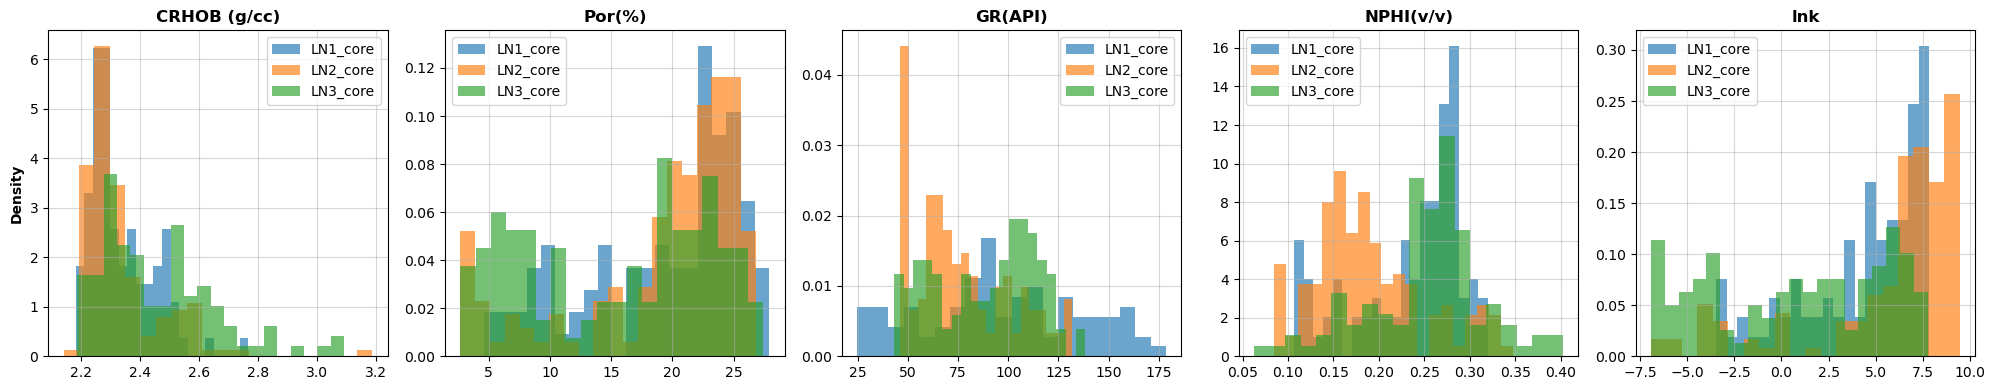

In [5]:
my_columns = ['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']

plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.hist(LN1_core[my_columns].iloc[:,i], bins=20, density=True, alpha=0.66, label='LN1_core')
    plt.hist(LN2_core[my_columns].iloc[:,i], bins=20, density=True, alpha=0.66, label='LN2_core')
    plt.hist(LN3_core[my_columns].iloc[:,i], bins=20, density=True, alpha=0.66, label='LN3_core')
    plt.title(my_columns[i], weight='bold')
    plt.ylabel('Density', weight='bold') if i==0 else None
    plt.legend()
    plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

In [238]:
# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=10, random_state=42)
xgb_model.fit(X_train.values, y_train.values)

y_train_pred = xgb_model.predict(X_train.values)
y_test_pred  = xgb_model.predict(X_test.values)
print('Pred: train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))
print('MSE:  train: {:.3f}  | test: {:.3f}'.format(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R2:   train: {:.3f}  | test: {:.3f}'.format(r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Pred: train: (201,) | test: (143,)
MSE:  train: 0.262  | test: 6.351
R2:   train: 0.986  | test: 0.615


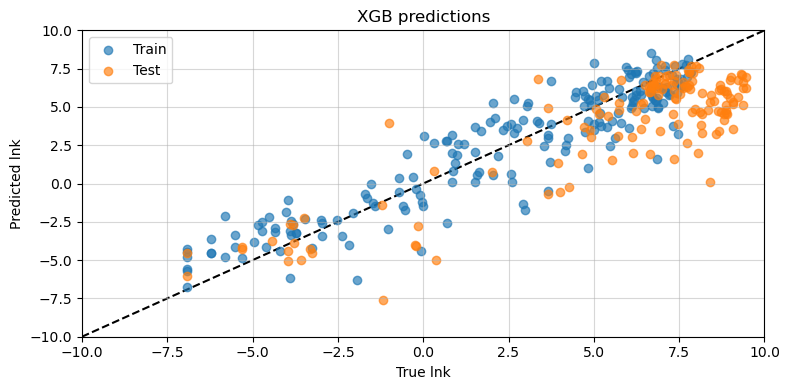

In [224]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred, marker='o', alpha=0.66, color='C1', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('XGB predictions')
plt.xlabel('True lnk'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### ANN

In [87]:
def make_model(n_layers:int=3, units:int=100, alpha:float=0.01, nonlinearity:str='relu'):

    def linear_bn_relu(x, units, nl=nonlinearity, a=alpha):
        x = layers.Dense(units, kernel_regularizer=regularizers.l2(a))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(nl)(x) #layers.PReLU()(x)
        return x

    inp = layers.Input(shape=(X_train.shape[1],))
    x = inp
    for _ in range(n_layers):
        x = linear_bn_relu(x, units)
    out = layers.Dense(1)(x)

    return Model(inputs=inp, outputs=out)

In [214]:
data_train = pd.concat([LN1_core, LN3_core])[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]
data_test  = LN2_core[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)', 'lnk']]

mu,   sd   = data_train.mean(), data_train.std()
dmin, dmax = data_train.min(), data_train.max()

# data_train_norm = (data_train - mu) / sd
# data_test_norm  = (data_test - mu) / sd
data_train_norm = (data_train - dmin) / (dmax - dmin)
data_test_norm  = (data_test - dmin) / (dmax - dmin)

X_train_norm = data_train_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_train_norm = data_train_norm['lnk']
print('X_train_norm: {} | y_train_norm: {}'.format(X_train_norm.shape, y_train_norm.shape))

X_test_norm = data_test_norm[['CRHOB (g/cc)', 'Por(%)','GR(API)', 'NPHI(v/v)']]
y_test_norm = data_test_norm['lnk']
print('X_test_norm:  {} | y_test_norm:  {}'.format(X_test_norm.shape, y_test_norm.shape))

X_train_norm: (201, 4) | y_train_norm: (201,)
X_test_norm:  (143, 4) | y_test_norm:  (143,)


In [215]:
model = make_model(n_layers=5, units=64, nonlinearity='relu')
print('# parameters: {:,}'.format(model.count_params()))

model.compile(optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-2), 
              loss      = losses.MeanSquaredError(), 
              metrics   = [metrics.MeanSquaredError()])

start = time()
fit = model.fit(X_train_norm, y_train_norm, 
                epochs           = 300, 
                batch_size       = 10,
                validation_split = 0.25,
                shuffle          = True,
                verbose          = 0)
print('Training time: {:.3f} seconds'.format(time()-start))
fit = pd.DataFrame(fit.history)

# Predict and back-transform
# y_train_pred_nn = model.predict(X_train_norm, verbose=False) * sd['lnk'] + mu['lnk']
# y_test_pred_nn  = model.predict(X_test_norm, verbose=False) * sd['lnk'] + mu['lnk']
y_train_pred_nn = model.predict(X_train_norm, verbose=False) * (dmax['lnk'] - dmin['lnk']) + dmin['lnk']
y_test_pred_nn  = model.predict(X_test_norm, verbose=False) * (dmax['lnk'] - dmin['lnk']) + dmin['lnk']
print('NN - train: {} | test: {}'.format(y_train_pred_nn.shape, y_test_pred_nn.shape))

print('MSE: train: {:.3f} | test: {:.3f}'.format(mean_squared_error(data_train['lnk'], y_train_pred_nn), mean_squared_error(data_test['lnk'], y_test_pred_nn)))
print('R2:  train: {:.3f} | test: {:.3f}'.format(r2_score(data_train['lnk'], y_train_pred_nn), r2_score(data_test['lnk'], y_test_pred_nn)))

# parameters: 18,625
Training time: 23.547 seconds
NN - train: (201, 1) | test: (143, 1)
MSE: train: 3.872 | test: 6.182
R2:  train: 0.796 | test: 0.625


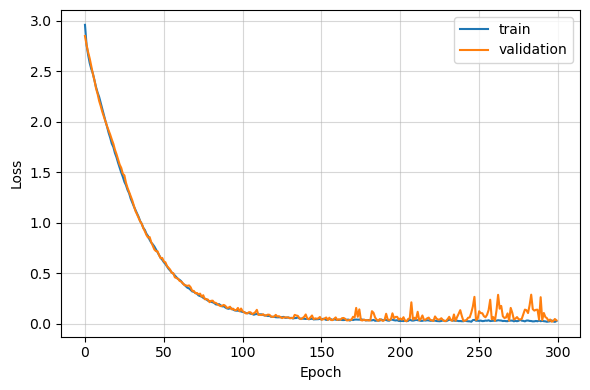

In [216]:
plt.figure(figsize=(6,4))
plt.plot(fit['loss'], label='train')
plt.plot(fit['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

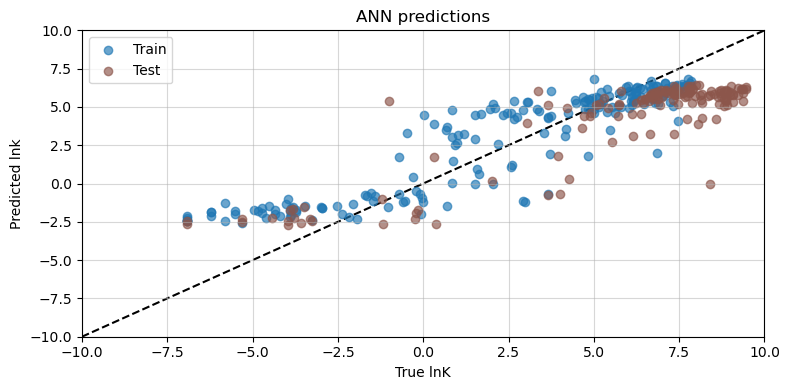

In [217]:
plt.figure(figsize=(8,4))

plt.scatter(y_train, y_train_pred_nn, marker='o', alpha=0.66, color='C0', label='Train')
plt.scatter(y_test, y_test_pred_nn, marker='o', alpha=0.66, color='tab:brown', label='Test')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)

plt.title('ANN predictions')
plt.xlabel('True lnK'); plt.ylabel('Predicted lnk')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-10,10); plt.ylim(-10,10)
plt.tight_layout()
plt.show()

***
### Ensemble

In [239]:
# Now, create stochastic simulations by generating random perturbations in the input features
mu_test, sd_test = X_test.mean(), X_test.std()
min_test, max_test = X_test.min(), X_test.max()

n_simulations = 100

random_inputs = np.zeros((n_simulations, depth.shape[0], X_test.shape[1]))
random_inputs_norm = np.zeros((n_simulations, depth.shape[0], X_test.shape[1]))

simulated_lnk_xgb = np.zeros((n_simulations, depth.shape[0]))
simulated_lnk_ann = np.zeros((n_simulations, depth.shape[0]))

start = time()
for i in range(n_simulations):
    for k in range(X_test.shape[-1]):
        random_inputs[i, :, k] = X_test.iloc[:,k] + np.random.normal(0, sd_test[k], size=depth.shape[0])
        #random_inputs_norm[i, :, k] = (random_inputs[i, :, k] - mu_test[k]) / sd_test[k] #normalize
        random_inputs_norm[i, :, k] = (random_inputs[i, :, k] - dmin[k]) / (dmax[k] - dmin[k])
    simulated_lnk_xgb[i] = xgb_model.predict(random_inputs[i])
    #simulated_lnk_ann[i] = model.predict(random_inputs_norm[i], verbose=False).squeeze() * sd['lnk'] + mu['lnk'] #predict and back-transform
    simulated_lnk_ann[i] = model.predict(random_inputs_norm[i], verbose=False).squeeze() * (dmax['lnk'] - dmin['lnk']) + dmin['lnk'] #predict and back-transform
print('Simulation time: {:.3f} seconds'.format(time()-start))

print('Random inputs ensemble: {}'.format(random_inputs.shape))
print('Simulated lnK ensemble XGB: {}'.format(simulated_lnk_xgb.shape))
print('Simulated lnK ensemble ANN: {}'.format(simulated_lnk_ann.shape))

Simulation time: 10.279 seconds
Random inputs ensemble: (100, 143, 4)
Simulated lnK ensemble XGB: (100, 143)
Simulated lnK ensemble ANN: (100, 143)


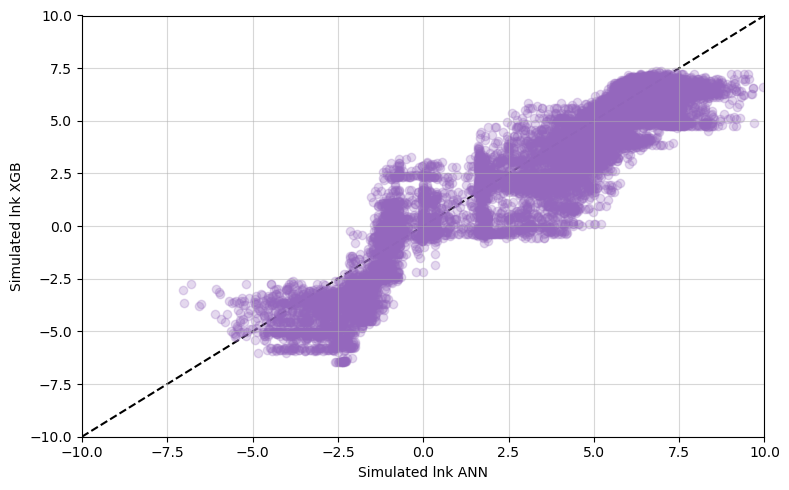

In [240]:
plt.figure(figsize=(8,5))
lims = 10
for i in range(n_simulations):
    plt.scatter(simulated_lnk_ann[i], simulated_lnk_xgb[i], marker='o', alpha=0.25, color='C4')
plt.axline([0,0], [1,1], color='k', ls='--', zorder=0)
plt.grid(True, which='both', alpha=0.5)
plt.xlim(-lims, lims); plt.ylim(-lims, lims)
plt.xlabel('Simulated lnk ANN'); plt.ylabel('Simulated lnk XGB')
plt.tight_layout()
plt.show()

***
### XGB Predictions

In [241]:
# uncertainty = P90 - P10
simulated_perct_xgb = np.percentile(simulated_lnk_xgb, [10, 90], axis=0)
simulated_unc_xgb   = simulated_perct_xgb[1] - simulated_perct_xgb[0]
simulated_std_xgb   = np.std(simulated_lnk_xgb, axis=0)

In [242]:
hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:orange']
err_lag = 5
lb, ub = 10, 90
unc_cutoff = 8

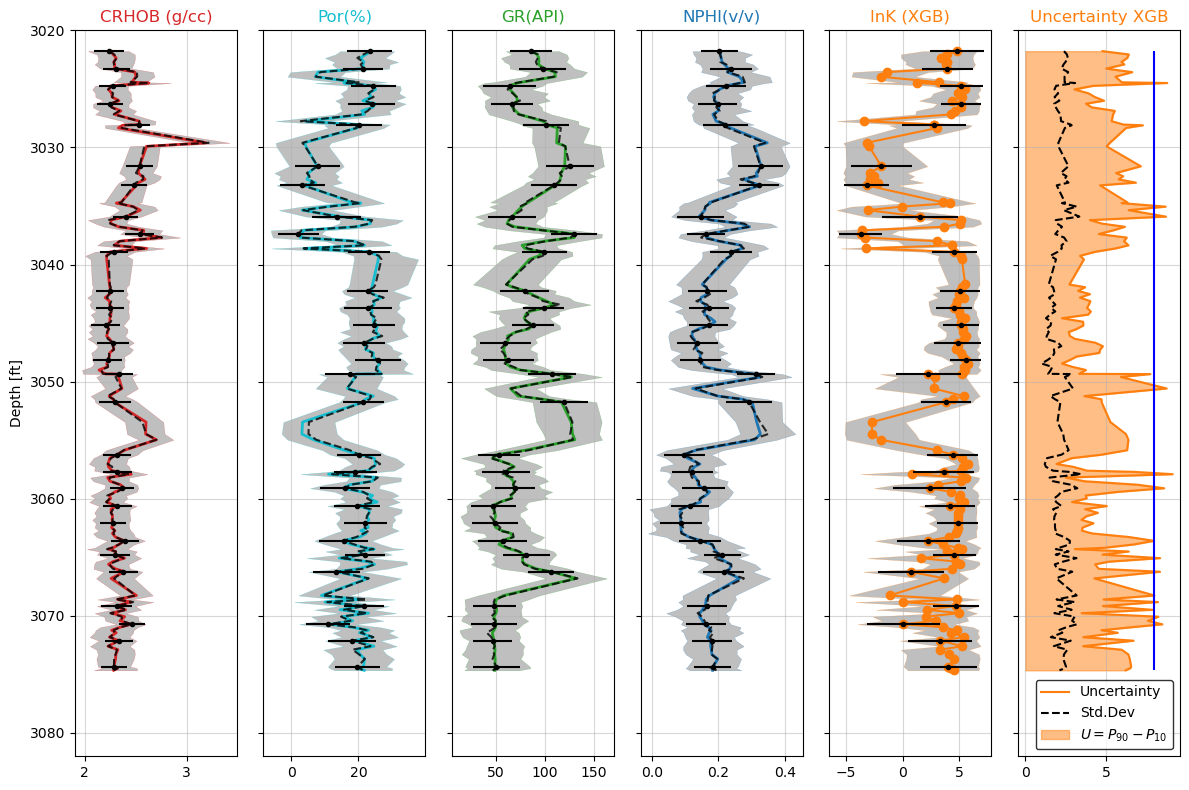

In [243]:
fig, axs = plt.subplots(1, 6, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-2].plot(simulated_lnk_xgb.mean(0), depth, color=hues[-1], marker='o')
axs[-2].fill_betweenx(depth, np.percentile(simulated_lnk_xgb, lb, axis=0), np.percentile(simulated_lnk_xgb, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-2].errorbar(simulated_lnk_xgb[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_xgb[:,::err_lag].std(0), fmt='.', color='k')
axs[-2].set_title('lnK (XGB)', color=hues[-1])

axs[-1].plot(simulated_unc_xgb, depth, color=hues[-1], label='Uncertainty')
axs[-1].plot(simulated_std_xgb, depth, color='k', ls='--', label='Std.Dev')
axs[-1].vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
axs[-1].fill_betweenx(depth, 0, simulated_unc_xgb, color=hues[-1], alpha=0.5, label='$U=P_{90}-P_{10}$')
axs[-1].legend(loc='lower right', edgecolor='k')
axs[-1].set_title('Uncertainty XGB', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
axs[0].set_ylim(3082, 3020)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

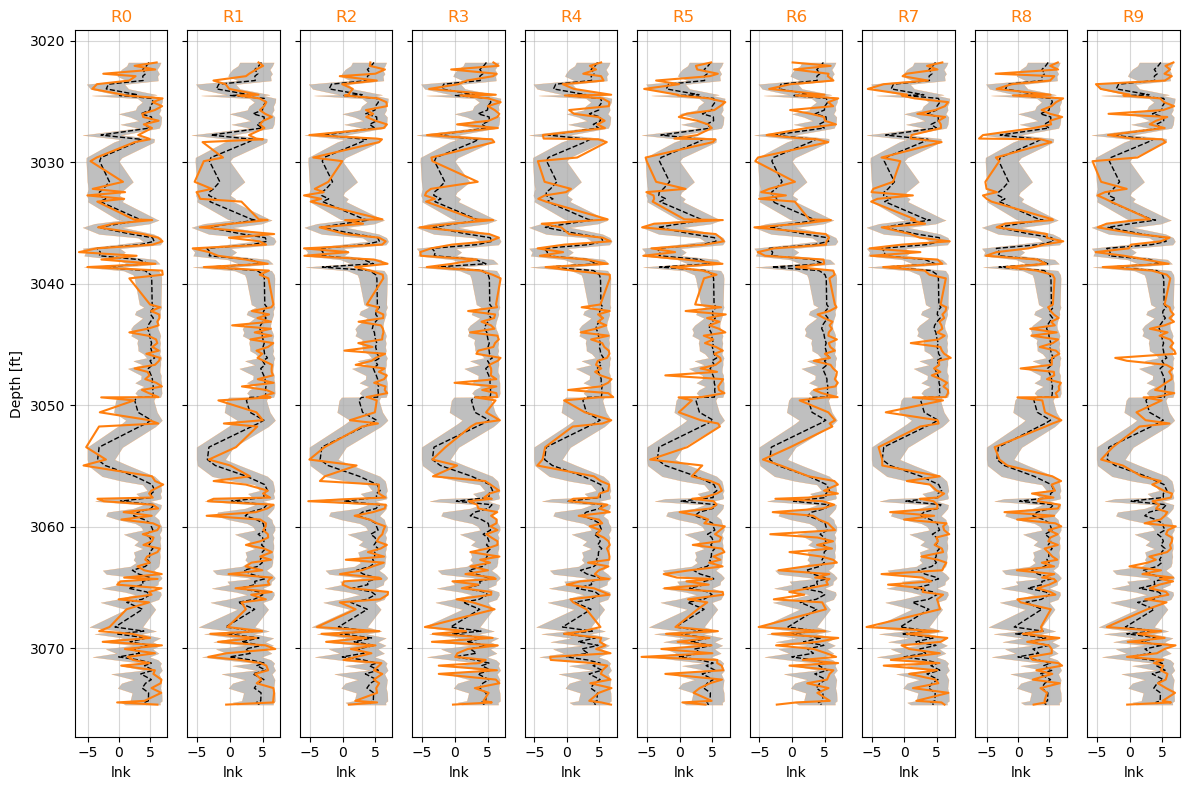

In [142]:
fig, axs = plt.subplots(1, 10, figsize=(12,8), sharey=True)
for j in range(10):
    ax = axs[j]
    ax.plot(simulated_lnk_xgb.mean(0), depth, color='k', ls='--', lw=1) # Ensemble mean
    ax.plot(simulated_lnk_xgb[j], depth, color=hues[-1])                # Individual simulation/realization
    ax.fill_betweenx(depth, np.percentile(simulated_lnk_xgb, lb, axis=0), np.percentile(simulated_lnk_xgb, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
    ax.set_title('R{}'.format(j), color=hues[-1])
ax.invert_yaxis()
[a.grid(True, which='both', alpha=0.5) for a in axs]
[a.set(xlabel='lnk') for a in axs]
axs[0].set_ylabel('Depth [ft]')
plt.tight_layout()
plt.show()

***
### ANN Predictions

In [179]:
# uncertainty = P90 - P10
simulated_perct_ann = np.percentile(simulated_lnk_ann, [10, 90], axis=0)
simulated_unc_ann   = simulated_perct_ann[1] - simulated_perct_ann[0]
simulated_std_ann   = np.std(simulated_lnk_ann, axis=0)

In [195]:
hues = ['tab:red', 'tab:cyan', 'tab:green', 'tab:blue', 'tab:brown']
err_lag = 5
lb, ub = 10, 90

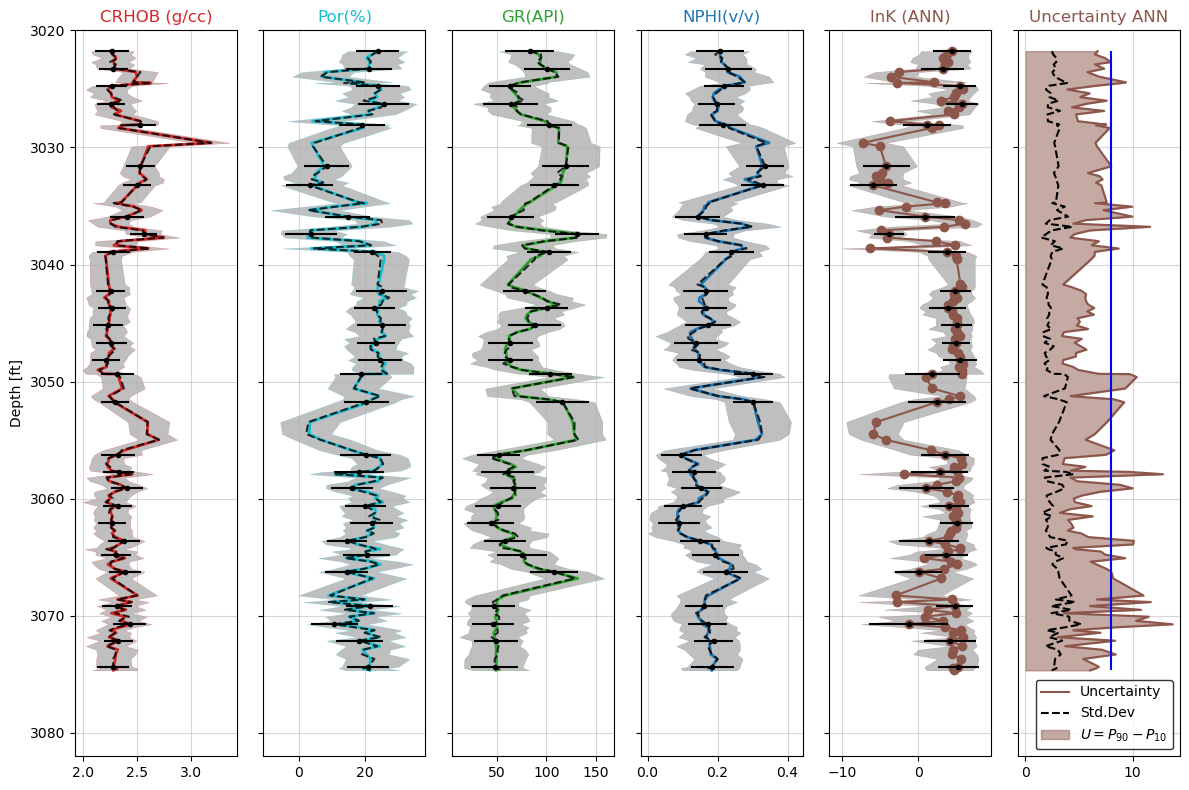

In [196]:
fig, axs = plt.subplots(1, 6, figsize=(12, 8), sharey=True)
for j in range(4):
    ax = axs[j]
    ax.fill_betweenx(depth, np.percentile(random_inputs[...,j], lb, axis=0), np.percentile(random_inputs[...,j], ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[j], lw=0.25)
    ax.plot(X_test.iloc[:,j], depth, color=hues[j], lw=2)                       # True
    ax.plot(random_inputs[:,:,j].mean(0), depth, color='k', ls='--', alpha=0.8) # Ensemble pred
    ax.errorbar(random_inputs[:,::err_lag,j].mean(0), depth[::err_lag], xerr=random_inputs[:,::err_lag,j].std(0), fmt='.', color='k')
    ax.set_title(X_test.columns[j], color=hues[j])

axs[-2].plot(simulated_lnk_ann.mean(0), depth, color=hues[-1], marker='o')
axs[-2].fill_betweenx(depth, np.percentile(simulated_lnk_ann, lb, axis=0), np.percentile(simulated_lnk_ann, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
axs[-2].errorbar(simulated_lnk_ann[:,::err_lag].mean(0), depth[::err_lag], xerr=simulated_lnk_ann[:,::err_lag].std(0), fmt='.', color='k')
axs[-2].set_title('lnK (ANN)', color=hues[-1])

axs[-1].plot(simulated_unc_ann, depth, color=hues[-1], label='Uncertainty')
axs[-1].plot(simulated_std_ann, depth, color='k', ls='--', label='Std.Dev')
axs[-1].vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
axs[-1].fill_betweenx(depth, 0, simulated_unc_ann, color=hues[-1], alpha=0.5, label='$U=P_{90}-P_{10}$')
axs[-1].legend(loc='lower right', edgecolor='k')
axs[-1].set_title('Uncertainty ANN', color=hues[-1])

ax.invert_yaxis()
axs[0].set_ylabel('Depth [ft]')
axs[0].set_ylim(3082, 3020)
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

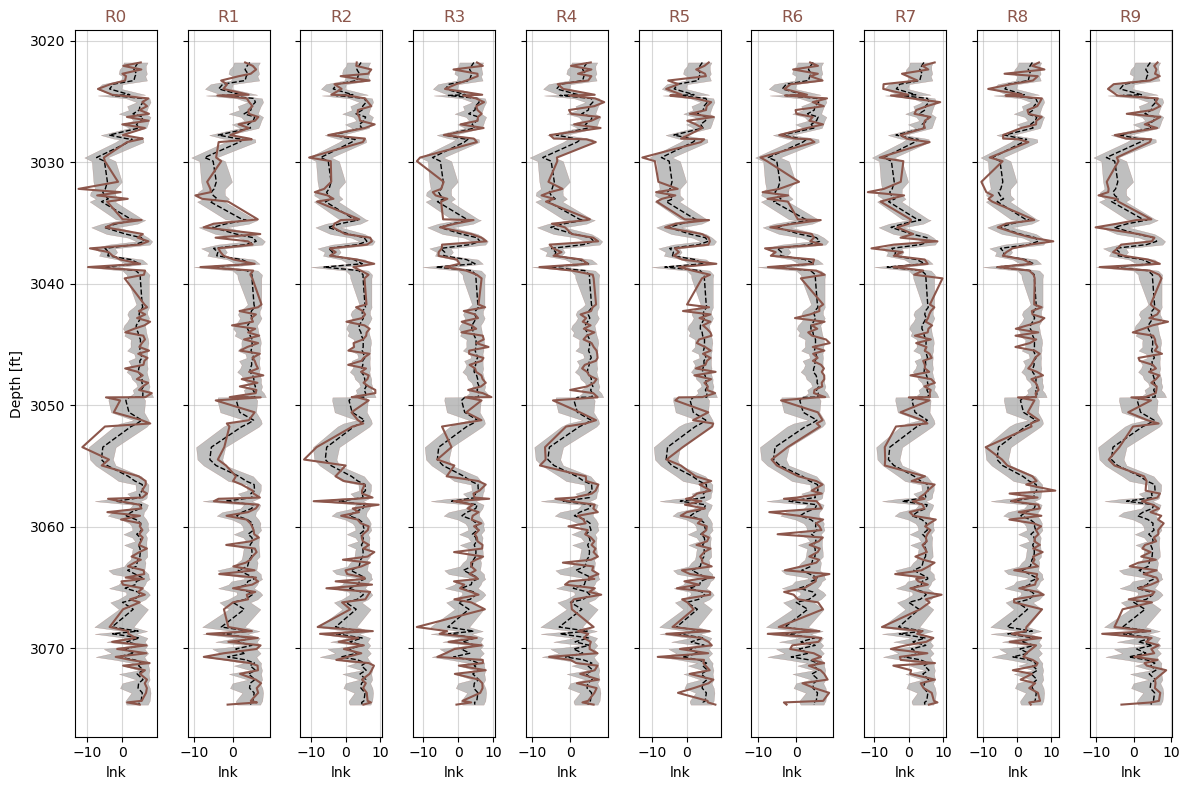

In [145]:
fig, axs = plt.subplots(1, 10, figsize=(12,8), sharey=True)
for j in range(10):
    ax = axs[j]
    ax.plot(simulated_lnk_ann.mean(0), depth, color='k', ls='--', lw=1) # Ensemble mean
    ax.plot(simulated_lnk_ann[j], depth, color=hues[-1])                # Individual simulation/realization
    ax.fill_betweenx(depth, np.percentile(simulated_lnk_ann, lb, axis=0), np.percentile(simulated_lnk_ann, ub, axis=0), color='gray', alpha=0.5, edgecolor=hues[-1], lw=0.25)
    ax.set_title('R{}'.format(j), color=hues[-1])
ax.invert_yaxis()
[a.grid(True, which='both', alpha=0.5) for a in axs]
[a.set(xlabel='lnk') for a in axs]
axs[0].set_ylabel('Depth [ft]')
plt.tight_layout()
plt.show()

***
### Compare UQ by regressor

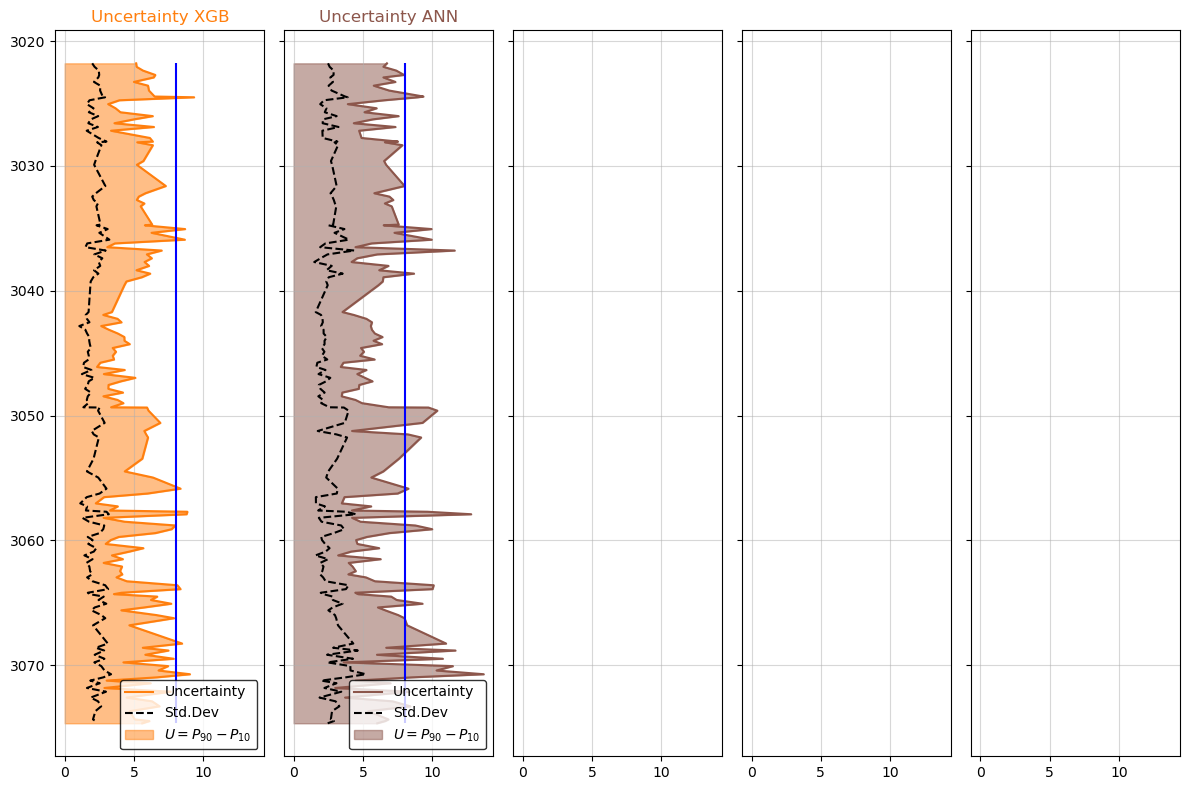

In [206]:
hues = ['tab:orange','tab:brown']

fig, axs = plt.subplots(1, 5, figsize=(12,8), sharex=True, sharey=True)
ax1, ax2, ax3, ax4, ax5 = axs

ax1.plot(simulated_unc_xgb, depth, color=hues[0], label='Uncertainty')
ax1.plot(simulated_std_xgb, depth, color='k', ls='--', label='Std.Dev')
ax1.vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
ax1.fill_betweenx(depth, 0, simulated_unc_xgb, color=hues[0], alpha=0.5, label='$U=P_{90}-P_{10}$')
ax1.legend(loc='lower right', edgecolor='k')
ax1.set_title('Uncertainty XGB', color=hues[0])

ax2.plot(simulated_unc_ann, depth, color=hues[1], label='Uncertainty')
ax2.plot(simulated_std_ann, depth, color='k', ls='--', label='Std.Dev')
ax2.vlines(unc_cutoff, depth.iloc[0], depth.iloc[-1], color='b')
ax2.fill_betweenx(depth, 0, simulated_unc_ann, color=hues[1], alpha=0.5, label='$U=P_{90}-P_{10}$')
ax2.legend(loc='lower right', edgecolor='k')
ax2.set_title('Uncertainty ANN', color=hues[1])

ax1.invert_yaxis()
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.show()

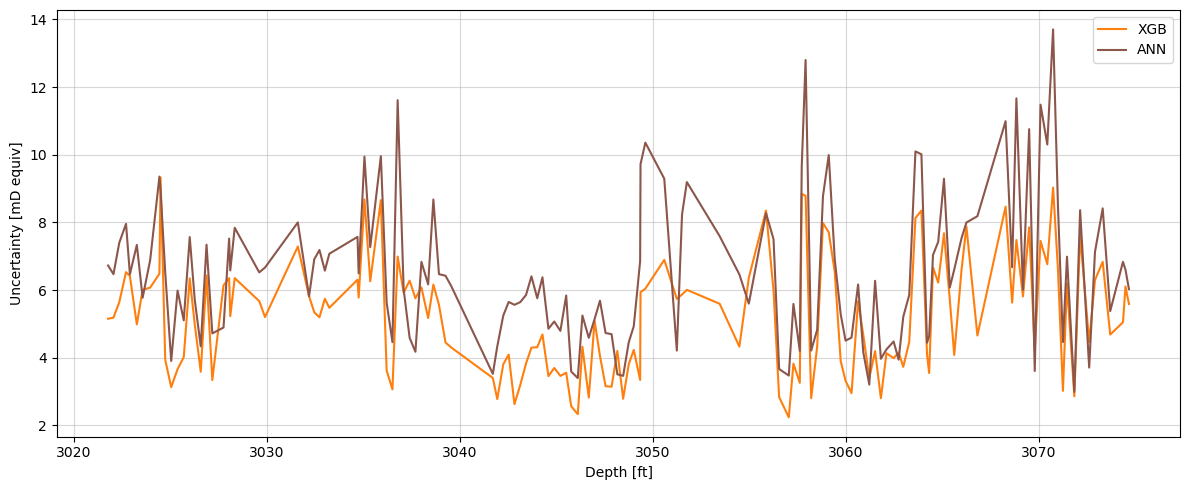

In [213]:
plt.figure(figsize=(12,5))
plt.plot(depth, simulated_unc_xgb, color=hues[0], label='XGB')
plt.plot(depth, simulated_unc_ann, color=hues[1], label='ANN')

plt.xlabel('Depth [ft]'); plt.ylabel('Uncertainty [mD equiv]')
plt.legend()
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

***
# END